In [1]:
# preprcessing function

def preprocess_observation(obs):
    img = obs[34:194:2, ::2]
    return np.mean(img,axis=2).reshape(80,80)/255.0

In [2]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("Breakout-v0")
obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)
img = preprocess_observation(obs)

In [25]:
#trying the render


for _ in range(1000):
    env.render()
    sample1= env.step(env.action_space.sample())

print(sample1)


(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0.0, True, {'ale.lives': 0})


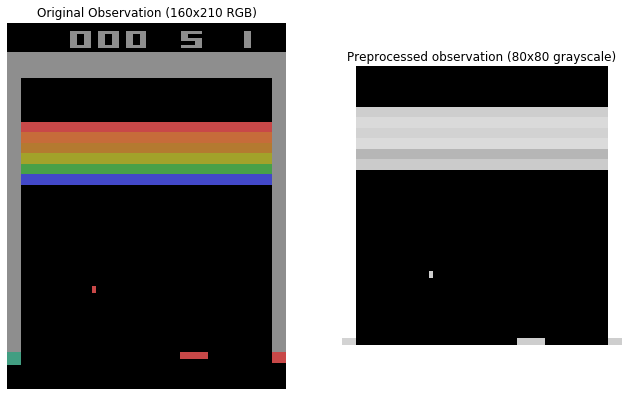

In [4]:
plt.figure(figsize=(11,7))
plt.subplot(121)
plt.title("Original Observation (160x210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (80x80 grayscale)")
plt.imshow(img, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

# here we can see that singleimage doesnot give us the direction and speed of the ball
# which are crucial for playing this game


In [5]:
# so here we need to combine several consecutive observations to create the
# environment state representation
# we can create a multi channel image with one channel per recent observation
# another is to merge all recent observations into a singlechannel images 
# in the case we dim the older images so that Dqn can distinguidh the
# past from the present

from collections import deque

def combine_observations_multichannel(preprocessed_observations):
    return np.array(preprocessed_observations).transpose([1,2,0])

def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.5):
    dimmed_observations = [obs * dim_factor ** index
                           for index, obs in enumerate( reversed(preprocessed_observations))]
    return np.max(np.array(dimmed_observations), axis=0)

n_observations_per_state =  3
preprocessed_observations = deque([], maxlen=n_observations_per_state)

obs = env.reset()
for step in range(10):
    obs, _,_,_ = env.step(1)
    preprocessed_observations.append(preprocess_observation(obs))
    

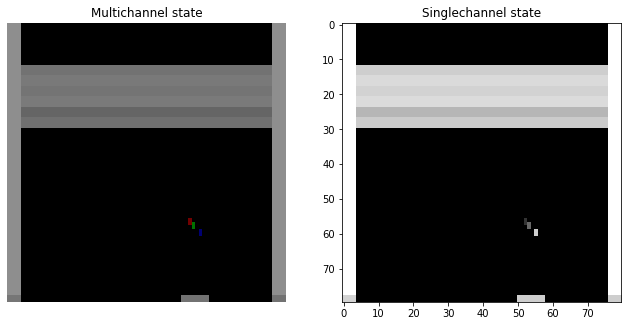

In [6]:
img1 = combine_observations_multichannel(preprocessed_observations)
img2 = combine_observations_singlechannel(preprocessed_observations)

plt.figure(figsize=(11,7))
plt.subplot(121)
plt.title("Multichannel state")
plt.imshow(img1, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.title("Singlechannel state")
plt.imshow(img2, interpolation="nearest", cmap="gray")
plt.show()

In [7]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

input_width = 80
input_height = 80
input_channels = 1

conv_n_maps = [32, 64, 64 ]
conv_kernel_sizes = [9, 5, 3]
conv_kernel_strides = [4, 2, 1]
conv_paddings = ['VALID'] * 3
conv_activation = [tf.nn.relu] * 3

n_hidden_in = 5 * 5 * 64
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n

he_init = tf.contrib.layers.variance_scaling_initializer()


W0704 07:03:03.897272 13248 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [8]:
def q_network(X_state,name):
    prev_layer = X_state
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size,strides, padding, activation in zip(
                conv_n_maps,conv_kernel_sizes, conv_kernel_strides, conv_paddings,
                conv_activation):
            prev_layer = tf.layers.conv2d(prev_layer, filters=n_maps,
                                          kernel_size=kernel_size, 
                                          strides=strides, padding=padding,
                                          kernel_initializer=he_init, activation=activation)
        flattened = tf.reshape(prev_layer, [-1, n_hidden_in])
        hidden = tf.layers.dense(flattened,n_hidden,
                                     activation=hidden_activation,
                                     kernel_initializer=he_init)
        outputs = tf.layers.dense(hidden, n_outputs, kernel_initializer=he_init)
        
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                           scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [9]:
X_state  = tf.placeholder(tf.float32,shape=(None, input_height,input_width, input_channels))
online_q_values, online_vars = q_network(X_state, 'q_networks/online')
target_q_values, target_vars = q_network(X_state, 'q_networks/target')
copy_ops = [var.assign(online_vars[name]) for name, var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

W0704 07:03:04.793523 13248 deprecation.py:323] From <ipython-input-8-2d9012532954>:10: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0704 07:03:04.794521 13248 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\layers\convolutional.py:424: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
W0704 07:03:04.844419 13248 deprecation.py:323] From <ipython-input-8-2d9012532954>:14: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.


In [10]:
learning_rate = 1e-3
momentum = 0.95

with tf.variable_scope('training') as scope:
    X_action  = tf.placeholder(tf.int32, shape=(None,))
    y = tf.placeholder(tf.float32, shape=(None,1))
    Q_target = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                             axis=1, keepdims=True)
    error = tf.abs(y- Q_target)
    loss = tf.reduce_mean(tf.square(error))
    
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    
    training_op = optimizer.minimize(loss, global_step = global_step)
    

In [11]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [12]:
class ReplayMemory(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
    def append(self, data):
        self.buf[self.index] = data
        self.index += 1
        self.index %= self.maxlen
        self.length = min(self.length + 1, self.maxlen)
    
    def sample(self, batch_size):
        return self.buf[np.random.randint(self.length, size=batch_size)]
    

In [13]:
replay_size = 200000
replay_memory = ReplayMemory(replay_size)

In [14]:
def sample_memories(batch_size):
    cols = [[], [], [], []]
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1,1), cols[3], cols[4].reshape(-1,1)

In [15]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 6000000

def epsilon_greedy(q_values, step):
    epsilon = min(eps_min,
                  eps_max- ((eps_max - eps_min) * (step/eps_decay_steps)))
    if np.random.random() < epsilon:
        return np.random.randint(n_outputs)
    return np.argmax(q_values)

In [16]:
n_steps = 10000000
training_start = 100000
training_interval = 4
save_steps = 1000
copy_steps = 10000
dsicount_rate =0.95
skip_start = 0
batch_size =50
iteration = 0
done = True
# to reset the environment at the start

loss_val = np.infty
game_length = 0
total_max_q = 0.0
mean_max_q = 0.0

checkpoint_path = "./breakout_dqn.ckpt"

In [17]:
# utility function to get the environment state for the model

def perform_action(action):
    preprocess_observations = []
    total_reward = 0.0
    for i in range(3):
        obs, reward,done,info = env.step(action)
        total_reward += reward
        if done:
            for _ in range(i,3):
                preprocess_observations.append(preprocess_observation(obs))
            break
        else:
            preprocess_observations.append(preprocess_observation(obs))
    return combine_observations_singlechannel(preprocess_observations).reshape(80, 80,1), total_reward, done

In [18]:
import os 

# main training loop 
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + '.index'):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration +=1 
        print("\rIteration {}\tTraining step {}/{} ({:.1f}) %\tLoss {:5f} \tMean Max-Q {:5f} ".format(
            iteration, step, n_steps, 100 * step / n_steps, loss_val, mean_max_q),
                 end='')
        if done:
            obs = env.reset()
            for _ in range(skip_start):
                obs, reward, done, info = env.step(0)
            state, reward, done = perform_action(0)
            
        
        # Evaluate the next action of the agent
        q_values = online_q_values.eval(feed_dict={X_state:[state]})
        action = epsilon_greedy(q_values, step)
        
        # online dqn plays the game
        next_state, reward, done = perform_action(action)
        
        # save the result in ReplayMemory
        replay_memory.append((state,action,reward,next_state, 1.0 -done))
        state = next_state
        
        # compute statistics which help us monitor how training is going
        total_max_q += q_values.max()
        game_length += 1
        if done :
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0
        
        # only train after the warmup rounds and only everyfew rounds
        if iteration < training_start or iteration % training_interval != 0:
            continue
        
        # sample memories from replay memeory
        X_state_val, X_action_val, rewards,X_next_state_val, continues = sample_memories(batch_size)
        next_q_values = target_q_values.eval(
            feed_dict={X_state:X_next_state_val}
        )
        max_next_q_values = np.max(next_q_values,axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values
        
        # train the online DQN
        _, loss_val = sesss.run([training_op, loss], feed_dict={
            X_state: X_state_val,
            X_action: X_action_val,
            y: y_val
        })
        
        # copy the online DQN to the taret DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()
        
        # regularly save the model
        if step and step % save_steps == 0:
            saver.save(sess,checkpoint_psth)

Iteration 100000	Training step 0/10000000 (0.0) %	Loss   inf 	Mean Max-Q 0.395146 

IndexError: list index out of range

In [ ]:
from IPython import display
%matplotlib inline

def plot_animation(frames, repeat=False, interval=40):
    plt.close()
    fig = plt.figure()
    for f in frames:
        plt.imshow(f)
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [ ]:
def run_episode(policy, n_max_steps=1000, frames_per_action=1):
    obs = env.reset()
    frames = []
    for i in range(n_max_steps):
        obs, reward, done, info = env.step(policy(obs,i))
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
    return frames

In [ ]:
preprocess_observations = []

with tf.Session() as sess:
    saver.restore(sess,checkpoint_path)
    
    def dqn_policy(obs, i):
        if len(preprocess_observations) < 3:
            preprocess_observations.append(preprocess_observation(obs))
            if len(preprocess_observations) == 3:
                state = combine_observations(preprocess_observations)
                q_values = online_q_values.eval(
                    feed_dict = {X_state: [state.reshape(80,80,1)]}
                )
                dqn_policy.cur_action = np.argmax(q_values)
            return dqn_policy.cur_action
        preprocess_observations[i%3] = preprocess_observation(obs)
        if i %3 == 2:
            state = combine_observations(preprocess_observations)
            q_values = online_q_values.eval(
                feed_dict={X_state: [state.reshape(80,80,1)]}
            )
            dqn_policy.cur_action = np.argmax(q_values)
        return dqn_policy.cur_action
    dqn_policy.cur_action = 0
    

    frames = run_episode(dqn_policy, n_max_steps=10000)

plot_animation(frames)